<a href="https://colab.research.google.com/github/Barthof/ImageMiningTeamB/blob/main/Citrus_leaves_VGG16_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [ ]:
# Install imbalance learning library
!pip install imblearn

In [ ]:
# Load dataset with info and
# split first 60% of dataset into train_ds and the other two 20% into test_ds and val_ds
(train_ds, test_ds, val_ds), info = tfds.load('citrus_leaves', as_supervised=True, with_info=True, split=["train[:60%]", "train[60%:80%]", "train[80%:]"], shuffle_files=True, batch_size=-1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/citrus_leaves/0.1.1.incompleteRLRQ5C/citrus_leaves-train.tfrecord


  0%|          | 0/594 [00:00<?, ? examples/s]

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.1. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [ ]:
# Split images and labels
image_train, label_train = tfds.as_numpy(train_ds)
image_test, label_test = tfds.as_numpy(test_ds)
image_val, label_val = tfds.as_numpy(val_ds)

In [ ]:
print(image_train.shape)
print(image_test.shape)
print(image_val.shape)
print(label_train.shape) 
print(label_test.shape)
print(label_val.shape)

(356, 256, 256, 3)
(119, 256, 256, 3)
(119, 256, 256, 3)
(356,)
(119,)
(119,)


Shape of image_train: (446, 256, 256, 3)

Shape of label_train: (446,)

Shape of image_test: (148, 256, 256, 3)

Shape of label_test: (148,)

In [ ]:
# Print matrix of image at index 0
print(image_train[0])

[[[217 202 203]
  [218 202 204]
  [220 204 205]
  ...
  [195 186 203]
  [192 186 201]
  [192 185 201]]

 [[218 203 203]
  [219 204 204]
  [220 204 205]
  ...
  [196 187 204]
  [192 185 200]
  [192 185 201]]

 [[218 204 204]
  [219 204 205]
  [220 204 205]
  ...
  [195 185 202]
  [194 186 203]
  [194 187 202]]

 ...

 [[ 76  51  25]
  [ 87  61  32]
  [ 91  62  38]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 62  39  16]
  [ 85  60  34]
  [100  72  45]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 56  35  18]
  [ 68  45  22]
  [102  76  48]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


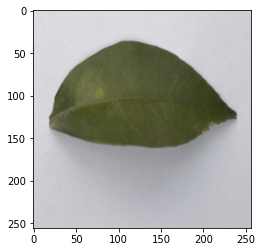

In [ ]:
# Display image
plt.imshow(image_train[1])

In [ ]:
# Extract informative features
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

print("Class names:", class_names)
print("Number of classes:", n_classes)
print("Size of training set:", len(image_train))
print("Unique labels in training set:", np.unique(label_train)) # [0: 'Black spot', 1: 'canker', 2: 'greening', 3: 'healthy']
print("Size of test set:", len(image_test))
print("Unique labels in test set:", np.unique(label_test)) # [0: 'Black spot', 1: 'canker', 2: 'greening', 3: 'healthy']

Class names: ['Black spot', 'canker', 'greening', 'healthy']
Number of classes: 4
Size of training set: 356
Unique labels in training set: [0 1 2 3]
Size of test set: 119
Unique labels in test set: [0 1 2 3]


In [ ]:
# amount per label in training set
# {0: 127, 1: 126, 2: 147, 3: 46}
print("training:", dict(sorted(Counter(label_train).items())))
# amount per label in test set
# {0: 42, 1: 37, 2: 57, 3: 12}
print("test:", dict(sorted(Counter(label_test).items())))

training: {0: 105, 1: 101, 2: 113, 3: 37}
test: {0: 32, 1: 29, 2: 47, 3: 11}


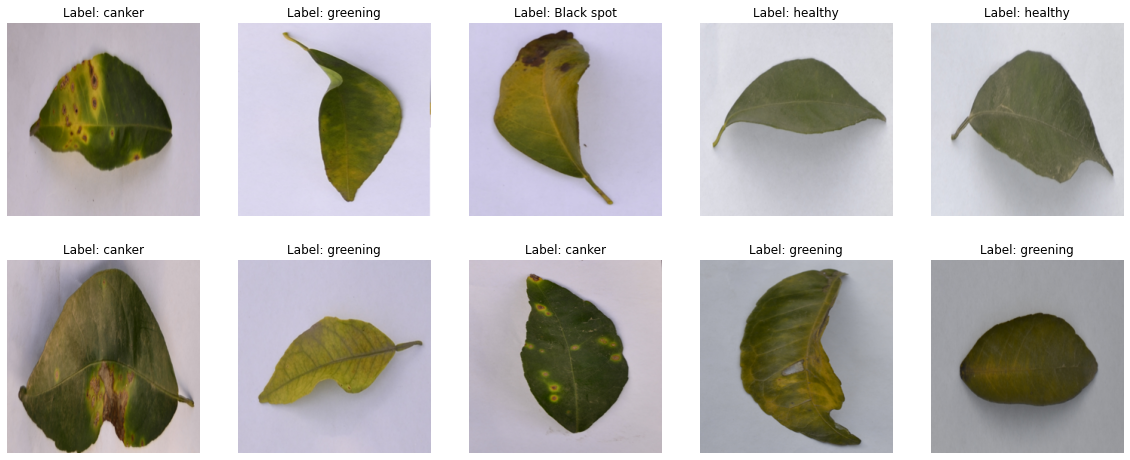

In [ ]:
import matplotlib.pyplot as plt

num_samples = 10

rand_samples = np.random.choice(np.arange(image_train.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = image_train[rand_samples[i]]
    label = label_train[rand_samples[i]]
    class_label = class_names[label]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {class_label}")
    ax.axis('off')
    ax.imshow(im)
plt.show()

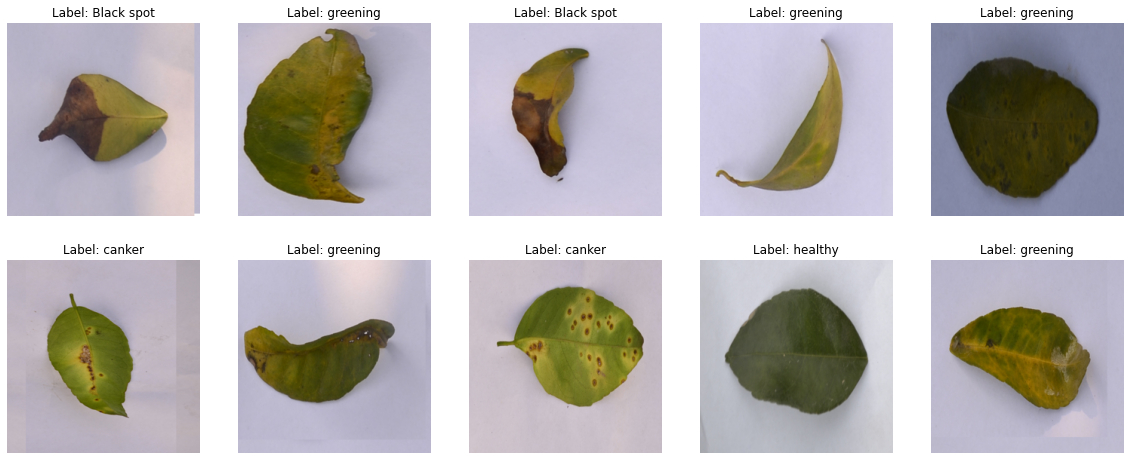

In [ ]:
num_samples = 10

rand_samples = np.random.choice(np.arange(image_test.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = image_test[rand_samples[i]]
    label = label_test[rand_samples[i]]
    class_label = class_names[label]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {class_label}")
    ax.axis('off')
    ax.imshow(im)
plt.show()

# Preprocessing

**Data Augmentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator as IDG

idg_train = IDG(
    rotation_range=180,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

idg_train.fit(image_train)

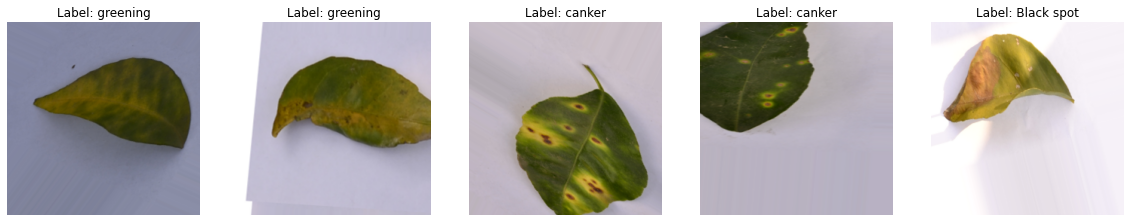

In [ ]:
fig = plt.figure(figsize=(20, 8))
for augmented_train, augmented_label in idg_train.flow(image_train, label_train, batch_size=-1):
    for i in range(0, 5):
        #plt.subplot()
        ax = fig.add_subplot(2, 5, i+1)
        label = augmented_label[i]
        class_label = class_names[label]
        ax.set_title(f"Label: {class_label}")
        ax.axis('off')
        augmented_train = augmented_train.astype('uint8')
        ax.imshow(augmented_train[i].reshape(256, 256, 3))
    break
plt.show()

In [ ]:
print(len(augmented_label))
# amount per label in augmented train set
# {0: 127, 1: 126, 2: 146, 3: 46}
print("augmented:", dict(sorted(Counter(augmented_label).items())))

355
augmented: {0: 105, 1: 101, 2: 113, 3: 36}


In [ ]:
image_train.shape, augmented_train.shape

((356, 256, 256, 3), (355, 256, 256, 3))

In [ ]:
# Append augmented data to original dataset
X_train = np.concatenate((image_train, augmented_train))
y_train = np.concatenate((label_train, augmented_label))

**Oversampling using SMOTE**

In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

# Import SMOTE from imblearn library
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot

0.8.1


Class=0, n=210 (29.536%)
Class=1, n=202 (28.411%)
Class=2, n=226 (31.786%)
Class=3, n=73 (10.267%)


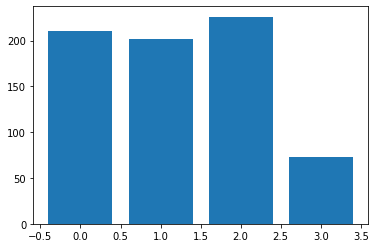

In [ ]:
# summarize distribution
counter = dict(sorted(Counter(y_train).items()))
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

**Reshape X_train data first**
*   First Flatten the image
*   Apply SMOTE on this flattened image data and its labels
*   Reshape the flattened image to RGB image

In [ ]:
from imblearn.over_sampling import SMOTE
    
sm = SMOTE(random_state=42)
    
train_rows=len(X_train)
X_train = X_train.reshape(train_rows,-1)

X_train, y_train = sm.fit_resample(X_train, y_train)
X_train = X_train.reshape(-1,256,256,3)

In [ ]:
# Print new shapes
print(X_train.shape) # (904, 256, 256, 3)
print(y_train.shape) # (904, 2)

(904, 256, 256, 3)
(904,)


Class=0, n=226 (25.000%)
Class=1, n=226 (25.000%)
Class=2, n=226 (25.000%)
Class=3, n=226 (25.000%)


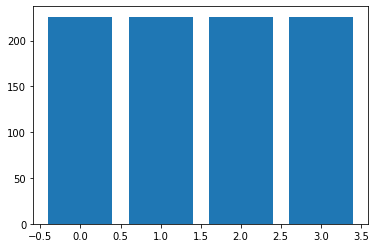

In [ ]:
# Summarize distribution after Smote
counter = dict(sorted(Counter(y_train).items()))
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

**Fix the name of other val and test data sett**

In [ ]:
# Fix the name and check the shape of validation images
X_val = image_val
print(X_val.shape)
# Fix the name and check the shape of test images
X_test = image_test
print(X_test.shape)

(119, 256, 256, 3)
(119, 256, 256, 3)


**Normalize data**

In [ ]:
X_train=X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

In [ ]:
#print(X_train[0])
print(X_val[0])

[[[0.81568627 0.77647059 0.81176471]
  [0.81960784 0.78039216 0.81568627]
  [0.81176471 0.77254902 0.80784314]
  ...
  [0.79607843 0.75686275 0.78823529]
  [0.78431373 0.75294118 0.78431373]
  [0.78823529 0.75294118 0.78823529]]

 [[0.81176471 0.77254902 0.80784314]
  [0.80784314 0.76862745 0.80392157]
  [0.81568627 0.77647059 0.81176471]
  ...
  [0.78823529 0.75294118 0.79215686]
  [0.78039216 0.74901961 0.79215686]
  [0.78039216 0.74901961 0.79215686]]

 [[0.81568627 0.77647059 0.81176471]
  [0.81176471 0.77254902 0.80784314]
  [0.81176471 0.77254902 0.81176471]
  ...
  [0.78823529 0.74509804 0.78823529]
  [0.78039216 0.74117647 0.78431373]
  [0.78039216 0.74117647 0.78431373]]

 ...

 [[0.75686275 0.7254902  0.78431373]
  [0.75686275 0.7254902  0.78431373]
  [0.75686275 0.7254902  0.78431373]
  ...
  [0.77647059 0.72941176 0.79215686]
  [0.78431373 0.74117647 0.79607843]
  [0.78431373 0.74117647 0.8       ]]

 [[0.76470588 0.7254902  0.78823529]
  [0.75686275 0.7254902  0.78431373]


**One Hot Encoding**

In [ ]:
# One hot encoder labels
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1, 1))

y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_val = enc.transform(label_val.reshape(-1, 1)).toarray()
y_test = enc.transform(label_test.reshape(-1, 1)).toarray()
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(904, 4)
(119, 4)
(119, 4)


# Transfer learning with VGG16

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

One requirement of the neural network model was to define the input shape, hence, all the images needed to in the same shape.

In [ ]:
X_train[0].shape

(256, 256, 3)

In [ ]:
input_shape = X_train[0].shape

In [ ]:
# Adapt input & output layer to our case
vgg = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

In [ ]:
#Freeze all VGG-16 layers and train only the classifier
#Basically means that we don't want to train the layers again but rather directly use them for our data
#for layer in vgg.layers:
#  layer.trainable = False

# Define the Model

In [ ]:
#Add Softmax classifier

x = Flatten()(vgg.output)
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
#ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
#ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# make smaller batches to prevent overflowing RAM
#ds_train = ds_train.batch(56)
#ds_val = ds_val.batch(56)

**Apply early stopping to avoid overfitting**

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)


**Model Training and fitting**

Used Adam as optimizer, Categorical Cross Entropy as Loss

Hyper Parameters

    Learning Rate - 0.0001


In [ ]:
# we need to recompile our model

adam=tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=adam,  # 1e-5 learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    shuffle = True,
)

Epoch 1/20
29/29 [==============================] - 42s 1s/step - loss: 1.2889 - accuracy: 0.3894 - val_loss: 1.0838 - val_accuracy: 0.5378
Epoch 2/20
29/29 [==============================] - 32s 1s/step - loss: 0.8714 - accuracy: 0.6560 - val_loss: 0.7573 - val_accuracy: 0.6471
Epoch 3/20
29/29 [==============================] - 32s 1s/step - loss: 0.6177 - accuracy: 0.7611 - val_loss: 0.5691 - val_accuracy: 0.7647
Epoch 4/20
29/29 [==============================] - 32s 1s/step - loss: 0.3949 - accuracy: 0.8739 - val_loss: 0.4421 - val_accuracy: 0.7563
Epoch 5/20
29/29 [==============================] - 32s 1s/step - loss: 0.2281 - accuracy: 0.9392 - val_loss: 0.3531 - val_accuracy: 0.8655
Epoch 6/20
29/29 [==============================] - 32s 1s/step - loss: 0.1235 - accuracy: 0.9757 - val_loss: 0.4220 - val_accuracy: 0.8151
Epoch 7/20
29/29 [==============================] - 32s 1s/step - loss: 0.0886 - accuracy: 0.9867 - val_loss: 0.3556 - val_accuracy: 0.8319
Epoch 8/20
29/29 [==

**Results**

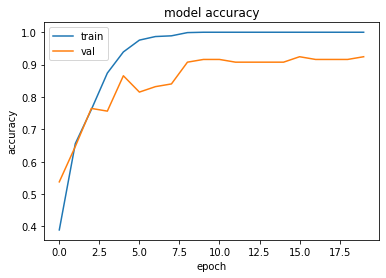

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

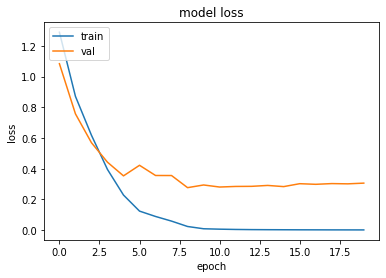

In [ ]:
# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluate the generated Model (Testing)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 349ms/step - loss: 0.7752 - accuracy: 0.8487


[0.7751988172531128, 0.848739504814148]

# Prediction for creating a Confusion matrix

In [ ]:
result=model.predict(X_test)

In [ ]:
result

array([[2.34224245e-01, 1.58674978e-02, 7.43339658e-01, 6.56862557e-03],
       [9.64945614e-01, 3.11732059e-03, 3.19368616e-02, 1.72041524e-07],
       [1.90561138e-06, 1.76857281e-12, 9.99998093e-01, 1.19361092e-11],
       [9.99690175e-01, 1.98486237e-06, 2.39890476e-04, 6.79496516e-05],
       [2.75974721e-01, 8.60258808e-07, 7.23919034e-01, 1.05340026e-04],
       [1.23055815e-05, 9.63597176e-06, 3.36055768e-06, 9.99974728e-01],
       [2.34074134e-04, 8.15387648e-06, 2.76455057e-06, 9.99755085e-01],
       [6.24740348e-09, 1.00000000e+00, 8.36430392e-09, 2.43705555e-12],
       [9.99987483e-01, 1.04364462e-05, 1.98818134e-06, 4.49619980e-10],
       [8.76795799e-02, 7.31342016e-06, 9.12309945e-01, 3.20211029e-06],
       [6.15838021e-02, 1.01804267e-06, 1.07280001e-04, 9.38307941e-01],
       [1.14898376e-05, 9.99987245e-01, 6.34757455e-11, 1.32335958e-06],
       [9.96297300e-01, 4.90859918e-07, 3.70205659e-03, 1.91157739e-07],
       [3.38036072e-04, 3.45569697e-06, 9.99617457e

In [ ]:
result[0]

array([0.23422424, 0.0158675 , 0.74333966, 0.00656863], dtype=float32)

In [ ]:
# Get the index of prediction 

y_true=[]
y_pred=[]
for i in range(len(result)):
    y_true.append(np.argmax(y_test[i]))
    y_pred.append(np.argmax(result[i]))

In [ ]:
print('True label', y_true)
print('Pred label:', y_pred)

True label [2, 1, 2, 0, 2, 3, 3, 1, 0, 2, 3, 1, 0, 2, 1, 0, 3, 1, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 0, 1, 0, 1, 3, 2, 2, 2, 3, 3, 1, 0, 1, 0, 2, 2, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 0, 3, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0, 2, 3, 2, 1, 2, 2, 2, 0, 0, 0, 3, 0, 0, 1, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 3, 2]
Pred label: [2, 0, 2, 0, 2, 3, 3, 1, 0, 2, 3, 1, 0, 2, 1, 0, 3, 1, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 0, 1, 0, 1, 3, 2, 0, 2, 3, 0, 0, 0, 1, 2, 2, 0, 2, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 1, 0, 1, 2, 2, 0, 2, 1, 1, 0, 2, 0, 3, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2, 3, 2, 1, 0, 0, 2, 2, 0, 0, 3, 1, 0, 1, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 0, 2, 0, 3, 2]


In [ ]:
np.unique(y_true),np.unique(y_pred)

(array([0, 1, 2, 3]), array([0, 1, 2, 3]))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Confusion Matrix

In [ ]:
len(y_test)

119

In [ ]:
mat=confusion_matrix(y_true, y_pred)
mat

array([[25,  1,  6,  0],
       [ 3, 25,  1,  0],
       [ 5,  0, 41,  1],
       [ 1,  0,  0, 10]])

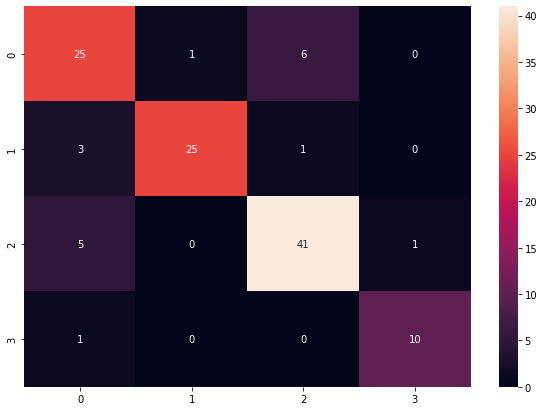

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

classes = ["0","1", "2", "3"]

'''
"0"--> label Black Spot
"1"--> label Canker
"2"--> label Greening
"3"--> label Healthy
'''


df_cfm = pd.DataFrame(mat, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True)
#cfm_plot.figure.savefig('/content/gdrive/MyDrive/result_CNN_1_5_REV/confusion_matrix.png')
plt.show()
#true y axis
# pred x axis

# Score of each class

In [ ]:
score_each_class=[]
temp=[]
for i in range(len(mat)):
    temp_sum=sum(mat[i])
    
    for j in range(len(mat[i])):
        temp.append(mat[i][j]/temp_sum)
    score_each_class.append(temp)
    temp=[]
    
score_each_class

[[0.78125, 0.03125, 0.1875, 0.0],
 [0.10344827586206896, 0.8620689655172413, 0.034482758620689655, 0.0],
 [0.10638297872340426, 0.0, 0.8723404255319149, 0.02127659574468085],
 [0.09090909090909091, 0.0, 0.0, 0.9090909090909091]]

In [ ]:
from sklearn.metrics import precision_score

precision_score(y_true, y_pred, average='macro')

0.8650225387357741

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average='macro')

0.8561875750350163

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro')

0.8597288676236045